# Notebook 02 — Feature Engineering

**Proyecto:** Thickener Water Recovery Sentinel (TWS)  
**Objetivo:** Construir la matriz de features para dos tareas de ML:

1. **Early warning** — clasificación binaria `target_event_30m` (horizonte 30 min)
2. **Diagnosis** — clasificación multiclase `event_type` (CLAY vs UF, solo durante eventos)

## Grupos de features

| Grupo | Descripción |
|-------|-------------|
| A. Rolling stats | Media, std, max, min en ventanas 15min–4h |
| B. Lags | Valores pasados en t-1, t-3, t-6, t-12 |
| C. Deltas | Tasas de cambio diff(1) y diff(6) |
| D. Tiempo cíclico | Hora del día y día de semana (sin/cos) |
| E. Flags | Régimen, modo de control, umbrales de proceso |
| F. Anomalía de sensor | Proxies de valores atascados, spikes, deriva |
| G. Interacciones | Productos de variables diagnósticas clave |

> **Nota de producción:** Las variables latentes de la simulación (`Clay_idx`, `PSD_fines_idx`, `UF_YieldStress_Pa`, `UF_capacity_factor`) no serían directamente medibles en planta.  
> Se incluyen aquí para demostrar el pipeline ML completo con el dataset sintético.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style='whitegrid', context='talk')

PATH = r'data/processed/thickener_timeseries_deadband0p27_sp4.parquet'
df_raw = pd.read_parquet(PATH)
df = df_raw.set_index('timestamp').sort_index().copy()

print(f'Dataset: {df.shape[0]:,} filas × {df.shape[1]} columnas')
print(f'Período: {df.index.min()} → {df.index.max()}')
print(f'Freq: {df.index.freq}')
print(f'\nBalance target_event_30m:')
print(df['target_event_30m'].value_counts(normalize=True).rename({0: 'No evento', 1: 'Evento 30m'}))

Dataset: 25,920 filas × 38 columnas
Período: 2026-01-01 00:00:00 → 2026-03-31 23:55:00
Freq: None

Balance target_event_30m:
target_event_30m
No evento     0.953356
Evento 30m    0.046644
Name: proportion, dtype: float64


## 1. Inventario de features base

Clasificamos las columnas del dataset según su rol en el pipeline ML.

In [2]:
# Columnas que son labels/targets (no usar como features)
LABELS = ['event_now', 'target_event_30m', 'event_type', 'event_type_raw']

# Columnas de metadatos/constantes (no informativas)
META = ['spec_limit_NTU', 'event_limit_NTU', 'Regime', 'ControlMode',
        'OperatorAction', 'RecommendedAction', 'ExpectedTradeoff']

# Features de proceso — disponibles en producción
PRODUCTION = [
    'Qf_m3h',            # Caudal feed medido
    'Solids_f_pct',      # % sólidos feed
    'Feedwell_Solids_pct',
    'FeedDilution_On',
    'FeedDilution_factor',
    'Qu_m3h',            # Caudal underflow
    'Qu_sp_delta_m3h',   # Delta setpoint operador
    'BedLevel_m',        # Nivel lecho
    'RakeTorque_kNm',    # Torque rastrillo
    'RakeTorque_pct',
    'Floc_gpt',          # Dosis floculante
    'Solids_u_pct',      # % sólidos underflow
    'Overflow_Turb_NTU', # Turbidez medida (con fallas)
    'WaterRecovery_proxy',
    'ActionScore_turb',
    'ActionScore_torque',
]

# Features latentes — solo en simulación (ground truth del proceso)
SIMULATION_LATENT = [
    'Clay_pct', 'Clay_idx',      # Contenido de arcilla
    'PSD_fines_idx',             # Índice de finos
    'UF_capacity_factor',        # Capacidad UF
    'Qu_base_m3h',               # Base Qu antes de acción
    'UF_YieldStress_Pa',         # Esfuerzo de fluencia (latente)
    'Bogging_factor',            # Factor de atascamiento
    'Overflow_Turb_NTU_clean',   # Turbidez real sin fallas (NUNCA usar como feature)
]

# Columnas auxiliares de dilución
AUX = ['Qf_pulp_m3h', 'Qf_dilution_m3h', 'Qf_total_m3h']

print('--- FEATURES BASE ---')
print(f'Producción: {len(PRODUCTION)}')
print(f'Latentes simulación: {len(SIMULATION_LATENT)}')
print(f'Labels/targets: {len(LABELS)}')
print(f'\n⚠ Overflow_Turb_NTU_clean: NUNCA usar como feature (es equivalente al label)')

--- FEATURES BASE ---
Producción: 16
Latentes simulación: 8
Labels/targets: 4

⚠ Overflow_Turb_NTU_clean: NUNCA usar como feature (es equivalente al label)


## 2. Features temporales (ciclicidad)

El proceso tiene ritmos diurnos (turnos, demanda). Codificamos hora del día y día de semana con sin/cos para preservar la continuidad cíclica.

Features temporales:
                     mean       std       min        max
hour_sin    -5.482583e-18  0.707120 -1.000000   1.000000
hour_cos    -2.741291e-17  0.707120 -1.000000   1.000000
dow_sin     -1.083253e-02  0.703489 -0.974928   0.974928
dow_cos      2.472455e-03  0.710647 -0.900969   1.000000
hour_of_day  1.150000e+01  6.922320  0.000000  23.000000


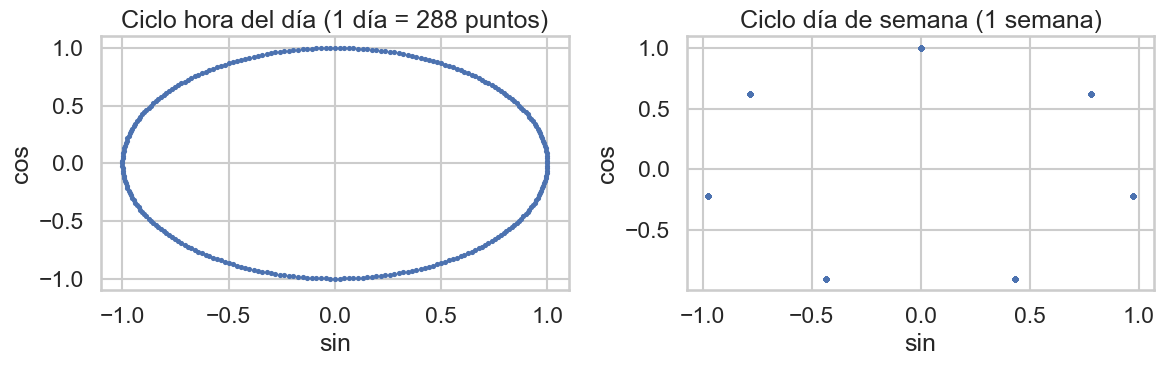

In [3]:
feat = pd.DataFrame(index=df.index)

# ---- Hora del día (ciclo 24h = 288 pasos a 5 min) ----
hour_frac = df.index.hour + df.index.minute / 60.0
feat['hour_sin'] = np.sin(2 * np.pi * hour_frac / 24.0)
feat['hour_cos'] = np.cos(2 * np.pi * hour_frac / 24.0)

# ---- Día de semana (ciclo 7 días) ----
dow = df.index.dayofweek.astype(float)
feat['dow_sin'] = np.sin(2 * np.pi * dow / 7.0)
feat['dow_cos'] = np.cos(2 * np.pi * dow / 7.0)

# ---- Hora raw (para interpretabilidad) ----
feat['hour_of_day'] = df.index.hour.astype(float)

print('Features temporales:')
print(feat.describe().T[['mean', 'std', 'min', 'max']])

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].scatter(feat['hour_sin'][:288], feat['hour_cos'][:288], s=5)
ax[0].set_title('Ciclo hora del día (1 día = 288 puntos)')
ax[0].set_xlabel('sin'); ax[0].set_ylabel('cos')
ax[1].scatter(feat['dow_sin'][:2016], feat['dow_cos'][:2016], s=5)
ax[1].set_title('Ciclo día de semana (1 semana)')
ax[1].set_xlabel('sin'); ax[1].set_ylabel('cos')
plt.tight_layout()
plt.show()

## 3. Rolling statistics

Para cada variable clave calculamos estadísticas en ventanas deslizantes de 15 min a 4 horas.  
No se usa `shift(1)` previo: la observación actual en tiempo `t` está disponible para predecir `t+30min`.

In [4]:
# Ventanas en pasos de 5 min
WINDOWS = {'15m': 3, '30m': 6, '1h': 12, '2h': 24, '4h': 48}

# Variables a resumir
ROLL_VARS = [
    'Overflow_Turb_NTU',   # turbidez medida (producción)
    'BedLevel_m',
    'RakeTorque_pct',
    'Qu_m3h',
    'Solids_u_pct',
    'Floc_gpt',
    'Clay_idx',            # latente
    'PSD_fines_idx',       # latente
    'UF_YieldStress_Pa',   # latente
    'UF_capacity_factor',  # latente
]

roll_feats = []
for var in ROLL_VARS:
    s = df[var]
    for name, w in WINDOWS.items():
        r = s.rolling(window=w, min_periods=max(1, w // 2))
        roll_feats.append(r.mean().rename(f'{var}__rmean_{name}'))
        roll_feats.append(r.std().rename(f'{var}__rstd_{name}'))
        # max y min solo en ventanas cortas (evitar redundancia)
        if w <= 12:
            roll_feats.append(r.max().rename(f'{var}__rmax_{name}'))
            roll_feats.append(r.min().rename(f'{var}__rmin_{name}'))

roll_df = pd.concat(roll_feats, axis=1)
feat = pd.concat([feat, roll_df], axis=1)

print(f'Rolling features generados: {roll_df.shape[1]}')
print(f'NaN tras rolling (primeras filas): {roll_df.isna().sum().max()} max por columna')

Rolling features generados: 160
NaN tras rolling (primeras filas): 24 max por columna


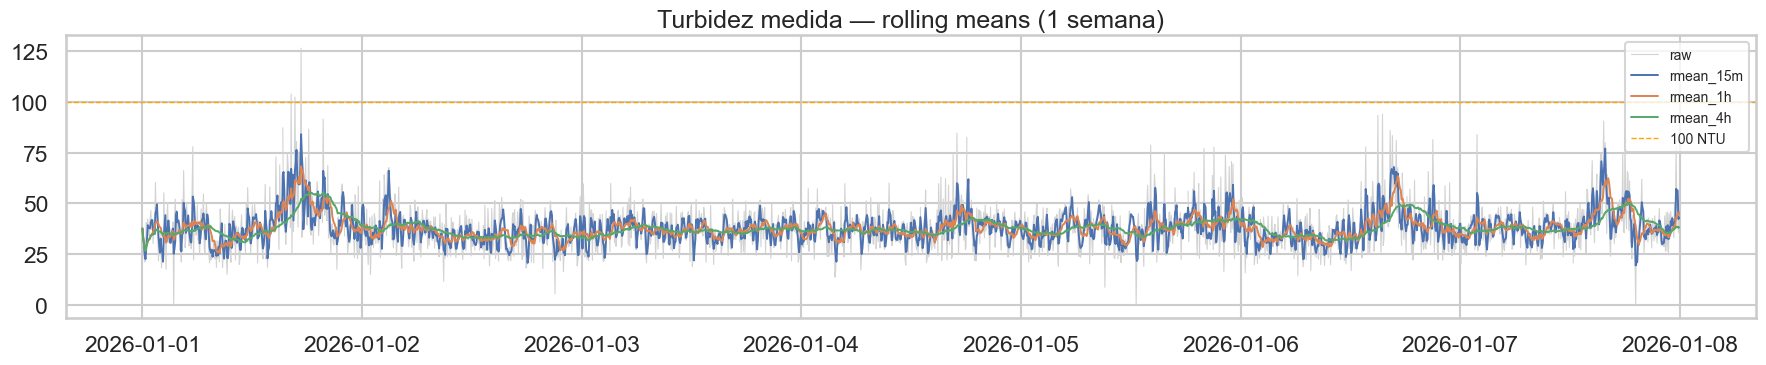

In [5]:
# Visualización: rolling mean de turbidez en distintas ventanas
sample = df.iloc[:2016].copy()  # 1 semana

fig, ax = plt.subplots(figsize=(18, 4))
ax.plot(sample.index, sample['Overflow_Turb_NTU'], color='lightgray', lw=0.8, label='raw')
for name, w in [('15m', 3), ('1h', 12), ('4h', 48)]:
    ax.plot(sample.index,
            sample['Overflow_Turb_NTU'].rolling(w, min_periods=1).mean(),
            lw=1.4, label=f'rmean_{name}')
ax.axhline(100, color='orange', ls='--', lw=1, label='100 NTU')
ax.set_title('Turbidez medida — rolling means (1 semana)')
ax.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()

## 4. Lag features

Valores históricos de las variables con mayor separación en el EDA (delta_over_IQR).  
Horizontes: t-1 (5min), t-3 (15min), t-6 (30min), t-12 (1h).

In [6]:
LAGS = [1, 3, 6, 12]

LAG_VARS = [
    'Overflow_Turb_NTU',
    'BedLevel_m',
    'RakeTorque_pct',
    'Clay_idx',
    'PSD_fines_idx',
    'UF_YieldStress_Pa',
    'Qu_m3h',
    'UF_capacity_factor',
]

lag_feats = []
for var in LAG_VARS:
    for k in LAGS:
        lag_feats.append(df[var].shift(k).rename(f'{var}__lag_{k}'))

lag_df = pd.concat(lag_feats, axis=1)
feat = pd.concat([feat, lag_df], axis=1)

print(f'Lag features generados: {lag_df.shape[1]}')
print(f'Primeras 3 features:')
print(lag_df.iloc[12:15, :3])  # skip initial NaN rows

Lag features generados: 32
Primeras 3 features:
                     Overflow_Turb_NTU__lag_1  Overflow_Turb_NTU__lag_3  \
timestamp                                                                 
2026-01-01 01:00:00                 46.602458                 34.050988   
2026-01-01 01:05:00                 36.960014                 41.825595   
2026-01-01 01:10:00                 41.757350                 46.602458   

                     Overflow_Turb_NTU__lag_6  
timestamp                                      
2026-01-01 01:00:00                 34.884870  
2026-01-01 01:05:00                 42.341421  
2026-01-01 01:10:00                 37.203863  


## 5. Delta / rate of change

La **tasa de cambio** de una variable es frecuentemente más predictiva que su valor absoluto.  
También computamos la **aceleración** (segunda derivada discreta) para detectar cambios bruscos.

Delta features generados: 21


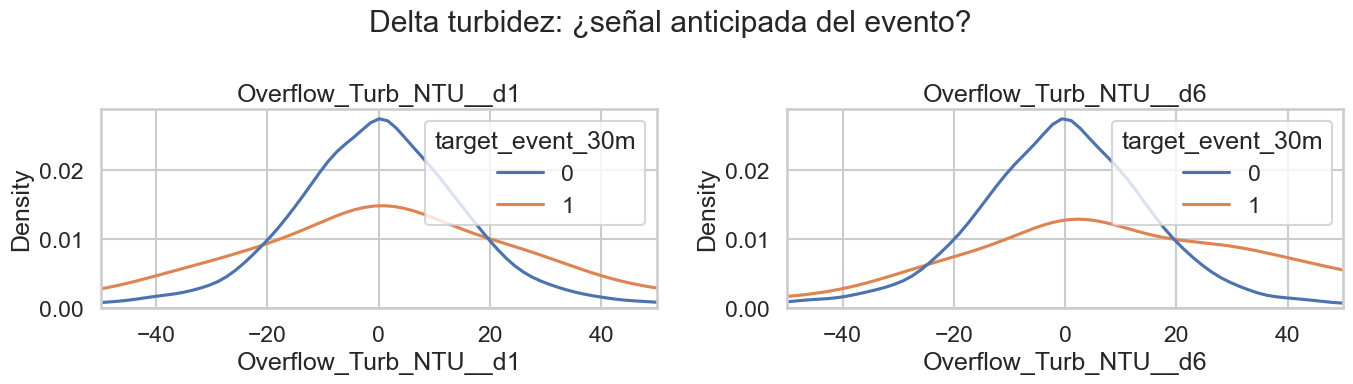

In [7]:
DELTA_VARS = [
    'Overflow_Turb_NTU',
    'BedLevel_m',
    'RakeTorque_pct',
    'Clay_idx',
    'PSD_fines_idx',
    'UF_YieldStress_Pa',
    'Qu_m3h',
]

delta_feats = []
for var in DELTA_VARS:
    s = df[var]
    d1 = s.diff(1)
    d6 = s.diff(6)
    delta_feats.append(d1.rename(f'{var}__d1'))
    delta_feats.append(d6.rename(f'{var}__d6'))
    # Aceleración (segunda derivada)
    delta_feats.append(d1.diff(1).rename(f'{var}__accel'))

delta_df = pd.concat(delta_feats, axis=1)
feat = pd.concat([feat, delta_df], axis=1)

print(f'Delta features generados: {delta_df.shape[1]}')

# Visualización: delta turbidez previo a eventos
tmp = pd.concat([
    df[['target_event_30m', 'Overflow_Turb_NTU']],
    delta_df[['Overflow_Turb_NTU__d1', 'Overflow_Turb_NTU__d6']]
], axis=1).dropna()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
for ax, col in zip(axes, ['Overflow_Turb_NTU__d1', 'Overflow_Turb_NTU__d6']):
    sns.kdeplot(tmp, x=col, hue='target_event_30m', common_norm=False, ax=ax)
    ax.set_title(col)
    ax.set_xlim(-50, 50)
plt.suptitle('Delta turbidez: ¿señal anticipada del evento?')
plt.tight_layout()
plt.show()

## 6. Flags y categóricas

Variables de régimen operacional, modo de control y umbrales de proceso codificadas como binarias.

In [8]:
flag_feats = pd.DataFrame(index=df.index)

# --- Régimen operacional (one-hot) ---
flag_feats['is_CLAY'] = (df['Regime'] == 'CLAY').astype(int)
flag_feats['is_UF']   = (df['Regime'] == 'UF').astype(int)

# --- Modo de control ---
flag_feats['is_MANUAL'] = (df['ControlMode'] == 'MANUAL').astype(int)

# --- Dilución activa ---
flag_feats['is_dilution'] = df['FeedDilution_On'].astype(int)

# --- Umbrales de proceso (estado de alarma) ---
flag_feats['turb_above_50']  = (df['Overflow_Turb_NTU'].fillna(0) > 50).astype(int)
flag_feats['turb_above_100'] = (df['Overflow_Turb_NTU'].fillna(0) > 100).astype(int)
flag_feats['bed_high']       = (df['BedLevel_m'] > 2.5).astype(int)
flag_feats['torque_high']    = (df['RakeTorque_pct'] > 80).astype(int)
flag_feats['clay_high']      = (df['Clay_idx'] > 0.65).astype(int)
flag_feats['uf_degraded']    = (df['UF_capacity_factor'] < 0.90).astype(int)

feat = pd.concat([feat, flag_feats], axis=1)

print('Distribución de flags:')
print(flag_feats.mean().sort_values(ascending=False).to_string())

Distribución de flags:
turb_above_50     0.349576
bed_high          0.327662
is_MANUAL         0.239352
is_CLAY           0.155556
is_UF             0.155556
clay_high         0.154398
torque_high       0.152932
turb_above_100    0.090046
uf_degraded       0.043789
is_dilution       0.010224


## 7. Proxies de anomalía de sensor (sensor health)

La turbidez medida (`Overflow_Turb_NTU`) tiene spikes, valores atascados y deriva.  
Estas features ayudan a detectar si la señal es confiable o hay una falla de instrumento.

Sensor anomaly features: 6
Stuck proxy activo: 0.8% del tiempo
Spike proxy activo: 0.0% del tiempo


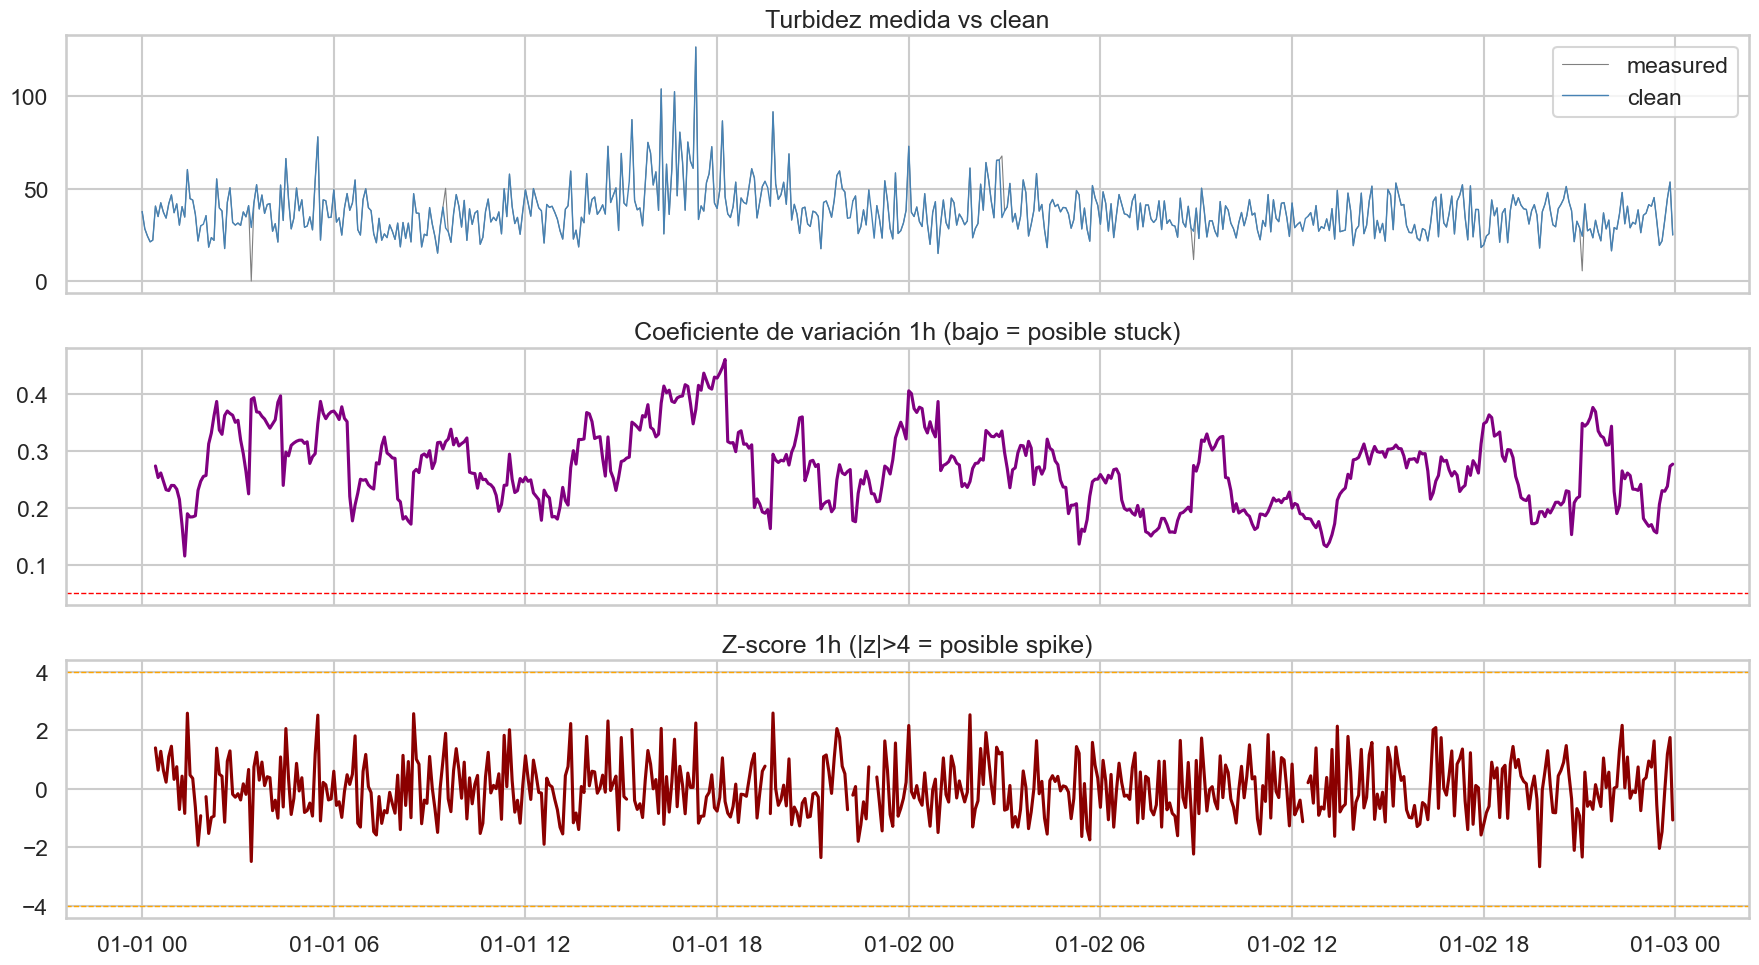

In [9]:
turb = df['Overflow_Turb_NTU'].copy()
sensor_feats = pd.DataFrame(index=df.index)

# --- Coeficiente de variación en 1h (bajo CV = posible stuck) ---
roll_12 = turb.rolling(12, min_periods=6)
rmean_12 = roll_12.mean()
rstd_12  = roll_12.std()
sensor_feats['turb_cv_1h'] = rstd_12 / (rmean_12.abs() + 1.0)

# --- Proxy de sensor atascado: rolling std muy bajo ---
sensor_feats['turb_stuck_proxy'] = (rstd_12 < 0.5).astype(float)

# --- Z-score respecto a media 1h: valor muy alejado = posible spike ---
sensor_feats['turb_zscore_1h'] = (turb - rmean_12) / (rstd_12 + 1e-3)
sensor_feats['turb_spike_proxy'] = (sensor_feats['turb_zscore_1h'].abs() > 4.0).astype(float)

# --- Error respecto a rolling median 2h (robusto a spikes) ---
roll_24 = turb.rolling(24, min_periods=12)
sensor_feats['turb_dev_from_median_2h'] = turb - roll_24.median()

# --- Variación relativa respecto a ventana larga 4h (proxy de deriva) ---
rmean_48 = turb.rolling(48, min_periods=24).mean()
rmean_6  = turb.rolling(6,  min_periods=3).mean()
sensor_feats['turb_drift_proxy'] = rmean_6 - rmean_48

feat = pd.concat([feat, sensor_feats], axis=1)

print(f'Sensor anomaly features: {sensor_feats.shape[1]}')
print(f"Stuck proxy activo: {sensor_feats['turb_stuck_proxy'].mean():.1%} del tiempo")
print(f"Spike proxy activo: {sensor_feats['turb_spike_proxy'].mean():.1%} del tiempo")

# Visualización
fig, axes = plt.subplots(3, 1, figsize=(18, 10), sharex=True)
w = df.iloc[:576]  # 2 días
idx = w.index

axes[0].plot(idx, w['Overflow_Turb_NTU'], color='gray', lw=0.8, label='measured')
axes[0].plot(idx, w['Overflow_Turb_NTU_clean'], color='steelblue', lw=1, label='clean')
axes[0].set_title('Turbidez medida vs clean'); axes[0].legend()

axes[1].plot(idx, sensor_feats.loc[idx, 'turb_cv_1h'], color='purple')
axes[1].axhline(0.05, color='red', ls='--', lw=1)
axes[1].set_title('Coeficiente de variación 1h (bajo = posible stuck)')

axes[2].plot(idx, sensor_feats.loc[idx, 'turb_zscore_1h'], color='darkred')
axes[2].axhline(4, color='orange', ls='--', lw=1)
axes[2].axhline(-4, color='orange', ls='--', lw=1)
axes[2].set_title('Z-score 1h (|z|>4 = posible spike)')

plt.tight_layout()
plt.show()

## 8. Interaction features

Productos de variables que combinan las dos firmas diagnósticas (CLAY y UF).

In [10]:
inter_feats = pd.DataFrame(index=df.index)

# Firma CLAY: arcilla × finos
inter_feats['clay_x_psd']       = df['Clay_idx'] * df['PSD_fines_idx']

# Carga mecánica combinada: esfuerzo × nivel de lecho
inter_feats['ys_x_bed']         = df['UF_YieldStress_Pa'] * df['BedLevel_m']

# Firma UF: capacidad reducida × caudal bajo
inter_feats['uf_stress']        = (1.0 - df['UF_capacity_factor']) * np.clip((220 - df['Qu_m3h']) / 220.0, 0, 1)

# Turbidez × torque: estado combinado de efluente y mecánica
inter_feats['turb_x_torque']    = (df['Overflow_Turb_NTU'].fillna(0) / 100.0) * (df['RakeTorque_pct'] / 100.0)

# Ratio carga sólida / underflow (proxy de densidad de flujo)
solids_flux = df['Qf_m3h'].fillna(df['Qf_total_m3h']) * (df['Solids_f_pct'] / 100.0)
inter_feats['solids_flux_ratio'] = solids_flux / (df['Qu_m3h'] + 1.0)

feat = pd.concat([feat, inter_feats], axis=1)

print(f'Interaction features: {inter_feats.shape[1]}')
print(inter_feats.describe().T[['mean', 'std', 'min', 'max']])

Interaction features: 5
                        mean        std       min         max
clay_x_psd          0.126752   0.215565  0.000000    0.806118
ys_x_bed           35.653121  50.256022  0.882375  210.000000
uf_stress           0.000873   0.005912  0.000000    0.101645
turb_x_torque       0.295004   0.427806  0.000000    3.919455
solids_flux_ratio   0.825184   0.134737  0.345768    1.606655


## 9. Features base (variables originales del proceso)

Incluimos las variables base del dataset como features de partida, excluyendo labels, metadatos y la turbidez clean (que actuaría como proxy del target).

In [11]:
BASE_FEAT_COLS = PRODUCTION + [c for c in SIMULATION_LATENT
                                if c != 'Overflow_Turb_NTU_clean'] + AUX

base_df = df[BASE_FEAT_COLS].copy()
feat = pd.concat([feat, base_df], axis=1)

# Adjuntamos targets al dataframe de features (no son features, solo para análisis)
feat['target_event_30m'] = df['target_event_30m']
feat['event_type']       = df['event_type']
feat['event_now']        = df['event_now']

print(f'Dimensiones antes de limpieza: {feat.shape}')

Dimensiones antes de limpieza: (25920, 268)


## 10. Limpieza: NaN, constantes y duplicados

In [12]:
# Separar features de targets para análisis
TARGET_COLS = ['target_event_30m', 'event_type', 'event_now']
feature_cols = [c for c in feat.columns if c not in TARGET_COLS]

# --- NaN rate por columna ---
nan_rate = feat[feature_cols].isna().mean().sort_values(ascending=False)
print('Top columnas con NaN (>1%):')
print(nan_rate[nan_rate > 0.01].to_string())

# Las primeras filas tienen NaN por rolling/lag — eliminar warmup inicial
WARMUP = 48  # 4h de warmup
feat = feat.iloc[WARMUP:].copy()
print(f'\nFilas tras quitar warmup ({WARMUP} pasos = 4h): {len(feat):,}')

# Rellenar NaN residuales (missings inyectados en sensores) con forward fill
feat[feature_cols] = feat[feature_cols].ffill().bfill()
print(f'NaN residuales tras ffill/bfill: {feat[feature_cols].isna().sum().sum()}')

# --- Features constantes (varianza cero) ---
std_vals = feat[feature_cols].std()
const_cols = std_vals[std_vals < 1e-8].index.tolist()
if const_cols:
    print(f'\nColumnas constantes (eliminadas): {const_cols}')
    feat.drop(columns=const_cols, inplace=True)
    feature_cols = [c for c in feature_cols if c not in const_cols]
else:
    print('\nNo hay columnas constantes.')

# --- Columnas duplicadas ---
dup_cols = feat[feature_cols].T.duplicated()
dup_names = dup_cols[dup_cols].index.tolist()
if dup_names:
    print(f'Columnas duplicadas eliminadas: {dup_names}')
    feat.drop(columns=dup_names, inplace=True)
    feature_cols = [c for c in feature_cols if c not in dup_names]

print(f'\nDimensiones finales del feature set: {feat[feature_cols].shape}')

Top columnas con NaN (>1%):
Overflow_Turb_NTU__accel     0.029977
Overflow_Turb_NTU__d6        0.020139
Overflow_Turb_NTU__d1        0.019985
Overflow_Turb_NTU__lag_12    0.010455
turb_dev_from_median_2h      0.010417
Overflow_Turb_NTU__lag_6     0.010224
turb_zscore_1h               0.010185
Overflow_Turb_NTU__lag_3     0.010108
Overflow_Turb_NTU__lag_1     0.010031

Filas tras quitar warmup (48 pasos = 4h): 25,872


NaN residuales tras ffill/bfill: 0

Columnas constantes (eliminadas): ['turb_spike_proxy']


Columnas duplicadas eliminadas: ['FeedDilution_On']

Dimensiones finales del feature set: (25872, 263)


## 11. Importancia de features — correlación y mutual information

### 11.1 Correlación de Pearson con `target_event_30m`

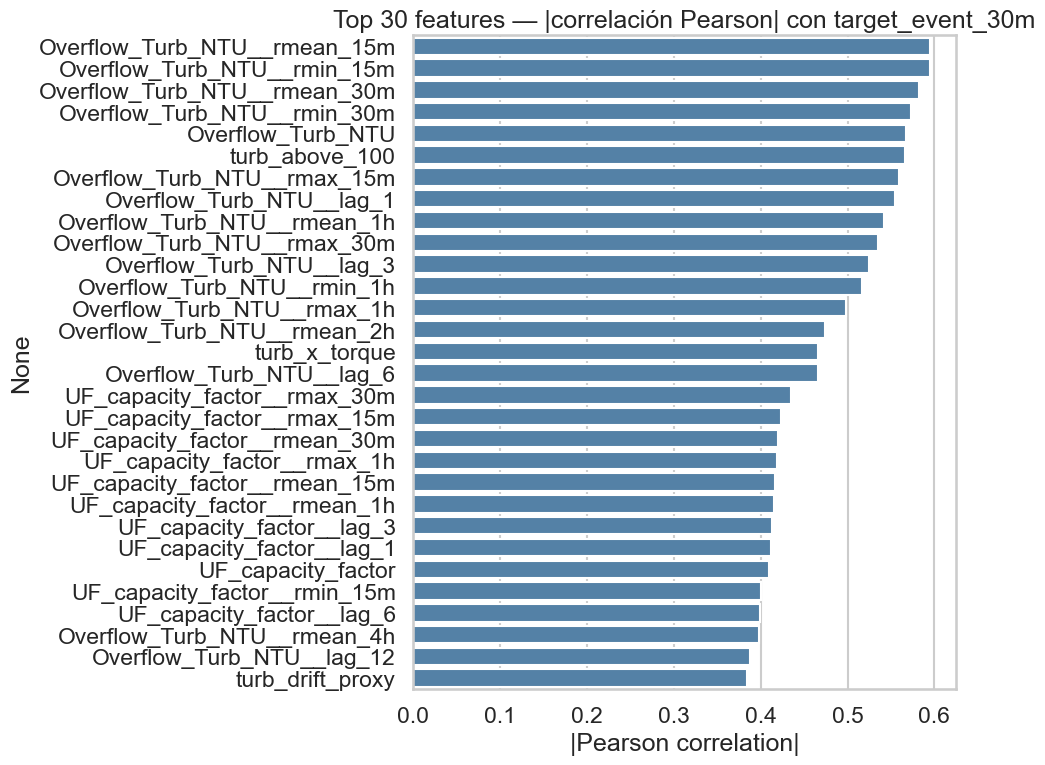

Top 15:
Overflow_Turb_NTU__rmean_15m    0.595120
Overflow_Turb_NTU__rmin_15m     0.594769
Overflow_Turb_NTU__rmean_30m    0.581942
Overflow_Turb_NTU__rmin_30m     0.573360
Overflow_Turb_NTU               0.567553
turb_above_100                  0.566316
Overflow_Turb_NTU__rmax_15m     0.559397
Overflow_Turb_NTU__lag_1        0.555212
Overflow_Turb_NTU__rmean_1h     0.541480
Overflow_Turb_NTU__rmax_30m     0.534725
Overflow_Turb_NTU__lag_3        0.524208
Overflow_Turb_NTU__rmin_1h      0.516712
Overflow_Turb_NTU__rmax_1h      0.497802
Overflow_Turb_NTU__rmean_2h     0.474476
turb_x_torque                   0.466193


In [13]:
corr = feat[feature_cols].corrwith(feat['target_event_30m']).abs().sort_values(ascending=False)

top30 = corr.head(30)
plt.figure(figsize=(10, 8))
sns.barplot(x=top30.values, y=top30.index, color='steelblue')
plt.title('Top 30 features — |correlación Pearson| con target_event_30m')
plt.xlabel('|Pearson correlation|')
plt.tight_layout()
plt.show()

print('Top 15:')
print(top30.head(15).to_string())

### 11.2 Mutual Information (captura relaciones no lineales)

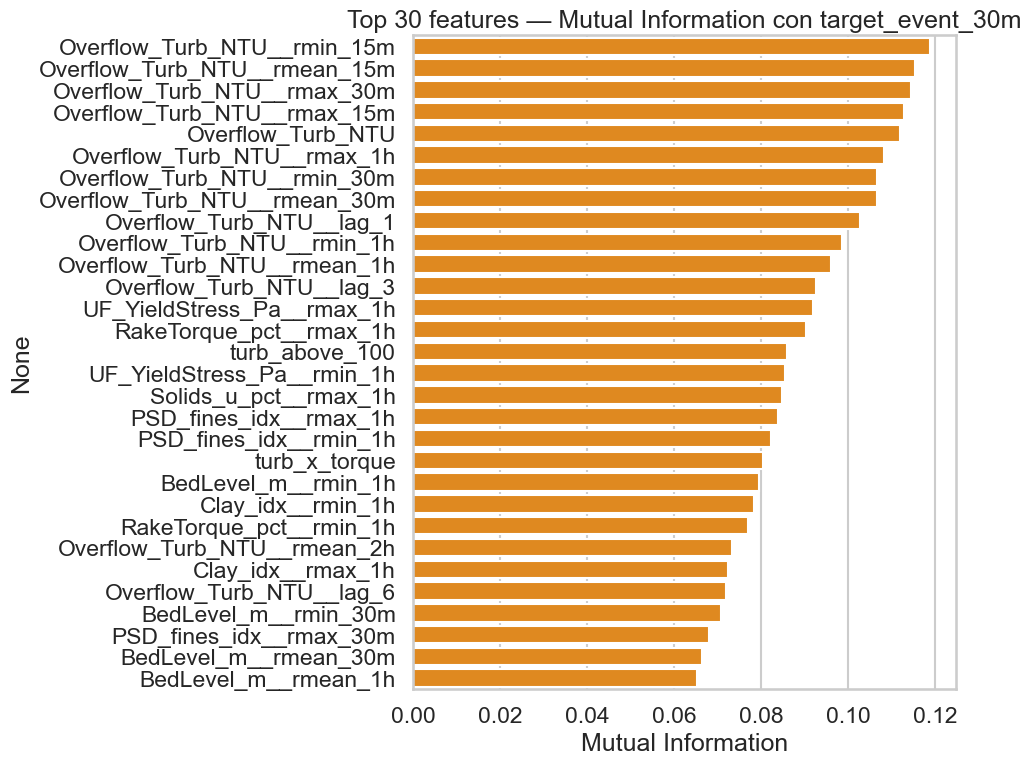

Top 15 (MI):
Overflow_Turb_NTU__rmin_15m     0.118788
Overflow_Turb_NTU__rmean_15m    0.115404
Overflow_Turb_NTU__rmax_30m     0.114421
Overflow_Turb_NTU__rmax_15m     0.112889
Overflow_Turb_NTU               0.111803
Overflow_Turb_NTU__rmax_1h      0.108175
Overflow_Turb_NTU__rmin_30m     0.106617
Overflow_Turb_NTU__rmean_30m    0.106489
Overflow_Turb_NTU__lag_1        0.102705
Overflow_Turb_NTU__rmin_1h      0.098531
Overflow_Turb_NTU__rmean_1h     0.095968
Overflow_Turb_NTU__lag_3        0.092511
UF_YieldStress_Pa__rmax_1h      0.091804
RakeTorque_pct__rmax_1h         0.090221
turb_above_100                  0.085875


In [14]:
# Usamos muestra para eficiencia
rng = np.random.default_rng(42)
idx_sample = rng.choice(len(feat), size=min(8000, len(feat)), replace=False)
X_sample = feat[feature_cols].iloc[idx_sample].fillna(0).values
y_sample = feat['target_event_30m'].iloc[idx_sample].values

mi = mutual_info_classif(X_sample, y_sample, random_state=42, n_neighbors=5)
mi_series = pd.Series(mi, index=feature_cols).sort_values(ascending=False)

top30_mi = mi_series.head(30)
plt.figure(figsize=(10, 8))
sns.barplot(x=top30_mi.values, y=top30_mi.index, color='darkorange')
plt.title('Top 30 features — Mutual Information con target_event_30m')
plt.xlabel('Mutual Information')
plt.tight_layout()
plt.show()

print('Top 15 (MI):')
print(top30_mi.head(15).to_string())

### 11.3 Separabilidad para diagnosis (CLAY vs UF)

delta_over_IQR entre CLAY y UF, solo durante eventos.

Eventos CLAY: 784 | UF: 425


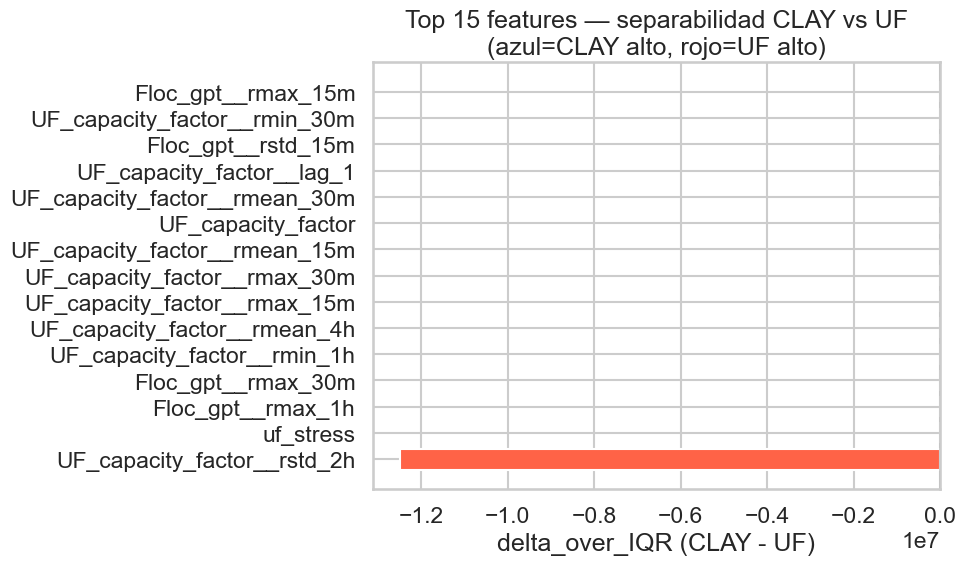

Top 15 separadores CLAY/UF:
                      feature  median_CLAY  median_UF  delta_over_IQR
  UF_capacity_factor__rstd_2h          0.0   0.012494   -1.249361e+07
                    uf_stress          0.0   0.023036   -4.973759e+00
            Floc_gpt__rmax_1h         35.0  27.274305    1.208562e+00
           Floc_gpt__rmax_30m         35.0  26.280220    1.167207e+00
  UF_capacity_factor__rmin_1h          1.0   0.779325    1.152369e+00
 UF_capacity_factor__rmean_4h          1.0   0.877020    1.133097e+00
 UF_capacity_factor__rmax_15m          1.0   0.790304    1.131369e+00
 UF_capacity_factor__rmax_30m          1.0   0.790304    1.131369e+00
UF_capacity_factor__rmean_15m          1.0   0.790304    1.131369e+00
           UF_capacity_factor          1.0   0.790304    1.131369e+00
UF_capacity_factor__rmean_30m          1.0   0.790304    1.126002e+00
    UF_capacity_factor__lag_1          1.0   0.790304    1.126002e+00
           Floc_gpt__rstd_15m          0.0   1.634816   -1.125

In [15]:
ev = feat[feat['event_now'] == 1].copy()
clay = ev[ev['event_type'] == 'CLAY']
uf   = ev[ev['event_type'] == 'UF']

print(f'Eventos CLAY: {len(clay)} | UF: {len(uf)}')

rows = []
for f in feature_cols:
    m_clay = float(clay[f].median())
    m_uf   = float(uf[f].median())
    iqr    = float(ev[f].quantile(0.75) - ev[f].quantile(0.25)) + 1e-9
    rows.append({'feature': f, 'median_CLAY': m_clay, 'median_UF': m_uf,
                 'delta': m_clay - m_uf, 'delta_over_IQR': (m_clay - m_uf) / iqr})

diag_sep = pd.DataFrame(rows).sort_values('delta_over_IQR', key=abs, ascending=False)

top15_diag = diag_sep.head(15)
colors = ['steelblue' if v > 0 else 'tomato' for v in top15_diag['delta_over_IQR']]
plt.figure(figsize=(10, 6))
plt.barh(top15_diag['feature'], top15_diag['delta_over_IQR'], color=colors)
plt.axvline(0, color='black', lw=1)
plt.title('Top 15 features — separabilidad CLAY vs UF\n(azul=CLAY alto, rojo=UF alto)')
plt.xlabel('delta_over_IQR (CLAY - UF)')
plt.tight_layout()
plt.show()

print('Top 15 separadores CLAY/UF:')
print(top15_diag[['feature', 'median_CLAY', 'median_UF', 'delta_over_IQR']].to_string(index=False))

### 11.4 Matriz de correlación — features seleccionadas

Revisamos multicolinealidad entre los top features.

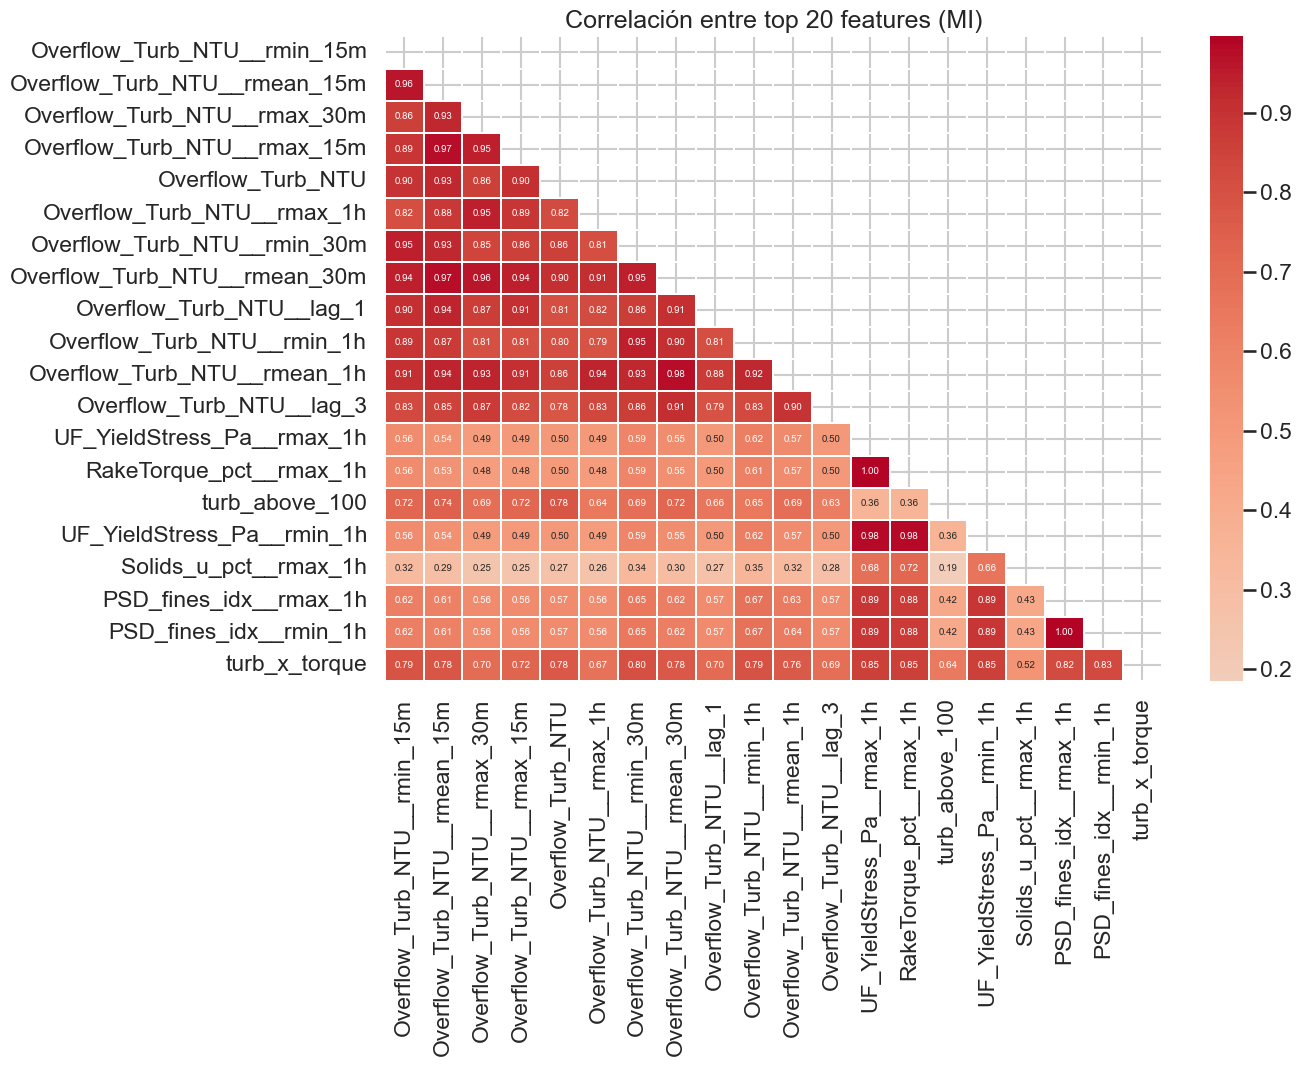

Pares con |corr| > 0.90 (posible redundancia):
  RakeTorque_pct__rmax_1h ↔ UF_YieldStress_Pa__rmax_1h: 0.996
  PSD_fines_idx__rmin_1h ↔ PSD_fines_idx__rmax_1h: 0.996
  UF_YieldStress_Pa__rmin_1h ↔ UF_YieldStress_Pa__rmax_1h: 0.984
  UF_YieldStress_Pa__rmin_1h ↔ RakeTorque_pct__rmax_1h: 0.984
  Overflow_Turb_NTU__rmean_1h ↔ Overflow_Turb_NTU__rmean_30m: 0.976
  Overflow_Turb_NTU__rmean_30m ↔ Overflow_Turb_NTU__rmean_15m: 0.974
  Overflow_Turb_NTU__rmax_15m ↔ Overflow_Turb_NTU__rmean_15m: 0.972
  Overflow_Turb_NTU__rmean_15m ↔ Overflow_Turb_NTU__rmin_15m: 0.964
  Overflow_Turb_NTU__rmean_30m ↔ Overflow_Turb_NTU__rmax_30m: 0.955
  Overflow_Turb_NTU__rmax_1h ↔ Overflow_Turb_NTU__rmax_30m: 0.948
  Overflow_Turb_NTU__rmin_30m ↔ Overflow_Turb_NTU__rmin_15m: 0.948
  Overflow_Turb_NTU__rmean_30m ↔ Overflow_Turb_NTU__rmin_30m: 0.948
  Overflow_Turb_NTU__rmin_1h ↔ Overflow_Turb_NTU__rmin_30m: 0.947
  Overflow_Turb_NTU__rmax_15m ↔ Overflow_Turb_NTU__rmax_30m: 0.945
  Overflow_Turb_NTU__rmean_30m ↔

In [16]:
# Seleccionamos top 20 por MI para el heatmap
top20_cols = mi_series.head(20).index.tolist()

corr_matrix = feat[top20_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(14, 11))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', center=0, linewidths=0.3,
            annot_kws={'size': 7})
plt.title('Correlación entre top 20 features (MI)')
plt.tight_layout()
plt.show()

# Pares altamente correlacionados (|r| > 0.90)
upper = corr_matrix.where(mask == False)
high_corr = [(r, c, round(upper.loc[r, c], 3))
             for r in upper.index for c in upper.columns
             if pd.notna(upper.loc[r, c]) and abs(upper.loc[r, c]) > 0.90]

if high_corr:
    print(f'Pares con |corr| > 0.90 (posible redundancia):')
    for r, c, v in sorted(high_corr, key=lambda x: abs(x[2]), reverse=True):
        print(f'  {r} ↔ {c}: {v}')
else:
    print('No hay pares con |corr| > 0.90 entre el top 20 features.')

## 12. Definición del feature set final

Construimos tres conjuntos de features para distintos escenarios de uso:

In [17]:
# ---- Feature set completo (todos los grupos) ----
FEATURES_ALL = feature_cols

# ---- Feature set de producción (sin variables latentes de simulación) ----
latent_prefixes = ('Clay_pct', 'Clay_idx', 'PSD_fines_idx',
                   'UF_capacity_factor', 'UF_YieldStress_Pa',
                   'Bogging_factor', 'Qu_base_m3h')

FEATURES_PROD = [c for c in FEATURES_ALL
                 if not any(c.startswith(p) or c == p for p in latent_prefixes)
                 and 'clay_x_psd' not in c
                 and 'ys_x_bed' not in c
                 and 'uf_stress' not in c
                 and c not in ('clay_high', 'uf_degraded')]

# ---- Top 30 por MI (para modelos ligeros / interpretabilidad) ----
FEATURES_TOP30 = mi_series.head(30).index.tolist()

print('=== Resumen de feature sets ===')
print(f'FEATURES_ALL    : {len(FEATURES_ALL):3d} features')
print(f'FEATURES_PROD   : {len(FEATURES_PROD):3d} features (sin variables latentes)')
print(f'FEATURES_TOP30  : {len(FEATURES_TOP30):3d} features (top MI)')

# Resumen por grupo
groups = {
    'Rolling stats' : [c for c in FEATURES_ALL if '__rmean_' in c or '__rstd_' in c or '__rmax_' in c or '__rmin_' in c],
    'Lag'           : [c for c in FEATURES_ALL if '__lag_' in c],
    'Delta'         : [c for c in FEATURES_ALL if '__d1' in c or '__d6' in c or '__accel' in c],
    'Tiempo cíclico': [c for c in FEATURES_ALL if c in ('hour_sin','hour_cos','dow_sin','dow_cos','hour_of_day')],
    'Flags'         : list(flag_feats.columns),
    'Sensor anomaly': list(sensor_feats.columns),
    'Interacciones' : list(inter_feats.columns),
    'Base variables': BASE_FEAT_COLS,
}
print('\nFeatures por grupo (en FEATURES_ALL):')
for g, cols in groups.items():
    n_in = len([c for c in cols if c in FEATURES_ALL])
    print(f'  {g:<20s}: {n_in:3d}')

=== Resumen de feature sets ===
FEATURES_ALL    : 263 features
FEATURES_PROD   : 162 features (sin variables latentes)
FEATURES_TOP30  :  30 features (top MI)

Features por grupo (en FEATURES_ALL):
  Rolling stats       : 160
  Lag                 :  32
  Delta               :  21
  Tiempo cíclico      :   5
  Flags               :  10
  Sensor anomaly      :   5
  Interacciones       :   5
  Base variables      :  25


## 13. Guardar feature set

In [18]:
import json
from pathlib import Path

out_dir = Path('data/processed')

# --- Guardar dataset con features engineered + targets ---
save_cols = FEATURES_ALL + TARGET_COLS
feat_out = feat[save_cols].reset_index()  # timestamp de vuelta como columna
feat_path = out_dir / 'thickener_features.parquet'
feat_out.to_parquet(feat_path, index=False)
print(f'Guardado: {feat_path}  ({feat_out.shape[0]:,} filas × {feat_out.shape[1]} cols)')

# --- Guardar catálogos de feature sets como JSON ---
catalogs = {
    'FEATURES_ALL': FEATURES_ALL,
    'FEATURES_PROD': FEATURES_PROD,
    'FEATURES_TOP30': FEATURES_TOP30,
    'TARGETS': TARGET_COLS,
}
catalog_path = out_dir / 'feature_catalogs.json'
with open(catalog_path, 'w') as f:
    json.dump(catalogs, f, indent=2)
print(f'Guardado: {catalog_path}')

# --- Resumen final ---
print('\n=== FEATURE SET FINAL ===')
print(f'Filas    : {feat_out.shape[0]:,}')
print(f'Features : {len(FEATURES_ALL)}')
print(f'Targets  : {TARGET_COLS}')
print(f'Balance target_event_30m: {feat["target_event_30m"].mean():.2%} positivos')
print(f'Balance event_type (eventos): CLAY={len(clay):,} | UF={len(uf):,}')

Guardado: data\processed\thickener_features.parquet  (25,872 filas × 267 cols)
Guardado: data\processed\feature_catalogs.json

=== FEATURE SET FINAL ===
Filas    : 25,872
Features : 263
Targets  : ['target_event_30m', 'event_type', 'event_now']
Balance target_event_30m: 4.67% positivos
Balance event_type (eventos): CLAY=784 | UF=425
